# XBern Confidence Intervals

This notebook aims to demo the `xbern_confidence_intervals` Python package. Please install via pip or consult the [README]() for details.

We generate some samples from the Exchangeable Bernoulli (XBern) distribution to demonstrate the effect of the xbern_confidence_intervals package. We refer to [Pillutla et al. (NeurIPS 2023)](https://arxiv.org/pdf/2305.18447.pdf) for details on XBern distributions and their confidence intervals.

_**XBern Distribution**_: A binary random vector $(X_1, \ldots, X_k) \in \{0, 1\}^k$ is said to be XBern if is is exchangeable, i.e., the distribution of $(X_1, \ldots, X_k)$ equals that of $(X_{\pi(1)}, \ldots, X_{\pi(k)})$ for any permutation $\pi$ on $\{1, \ldots, k\}$.


## Setup

Consider the two step procedure:

- sample $p \sim P$, where $P$ is some fixed distribution on $[0, 1]$ (e.g. the uniform distribution), and
- generate $X_1, \ldots, X_k \sim \text{Bernoulli}(\lambda p + (1-\lambda)q)$ for some fixed $\lambda, q \in [0, 1]$.

The binary random vector $(X_1, \ldots, X_k)$ is exchangeable, thus it is XBern. For $\lambda = 0$, we have that $X_{1:k}$ are independent. For $\lambda > 0$, $X_{1:k}$ are dependent but exchangeable. They grow more correlated as $\lambda$ grows larger, since $\text{Cov}(X_i, X_j) = \lambda^2 \text{Var}(p)$.

Here, $\lambda, q \in [0, 1]$ and the distribution $P$ are parameters that determine the resulting XBern distribution.

## Part 1: Generate Data

In [1]:
import math
import numpy as np
import pandas as pd

def generate_synthetic_data(
    n: int,
    k: int,
    lam: float,
    q: float,
    p_beta_params: tuple,
    seed: int,
) -> np.array:
    """Generate n samples of the synthetic XBern distribution in k dimensions.
    
        We take P = Beta(a, b) where (a, b) are given by p_beta_params.
    """
    rng = np.random.RandomState(seed)
    ps = rng.beta(*p_beta_params, size=n)  # shape = (n,).
    ps_mix = lam * ps + (1-lam) * q
    return (rng.rand(n, k) <= ps_mix[:, None]).astype(np.double)  # shape = (n, k).

In [2]:
n = 10000  # Number of samples.
k = 100  # Dimensionality.
lam = 0.01  # Constant for the data generation parameter.
samples = generate_synthetic_data(
    n, k, lam, q=0.1, p_beta_params=(2, 5), seed=0 
)
print(f'Shape = {samples.shape}, Empirical Mean = {samples.mean()}')

Shape = (10000, 100), Empirical Mean = 0.10173


## Part 2: Get Confidence Intervals on the Population Mean

We will use the `xbern_confidence_intervals` package to obtain confidence intervals on the true mean.


In [3]:
import xbern_confidence_intervals as xbern_ci



We will obtain a lower confidence bound `left` and upper confidence bound `right` such that the population mean of the XBern is no smaller than `left` with probability $1 - \beta$ and is no larger than `right` with probability $1-\beta$.

The confidence interval coverage guarantees are exact for the non-asymptotic Bernstein intervals while they are asymptotic (i.e., they hold in the limit that the sample size $n \to \infty$) for the Wilson intervals.

We compare the different methods: a better method gives tighter confidence intervals, i.e., a larger `left` and a smaller `right`.


In [4]:
beta = 0.05  # failure probability.

# Get asymptotic higher-order Wilson intervals.
left, right = xbern_ci.get_wilson_confidence_intervals(
    samples, beta
)
left.rename('Left C.I.').to_frame()

,Left C.I.
1st-Order Wilson,0.096865
2nd-Order Wilson,0.100607
4th-Order Wilson,0.100807


In [5]:
right.rename('Right C.I.').to_frame()

,Right C.I.
1st-Order Wilson,0.106810
2nd-Order Wilson,0.102779
4th-Order Wilson,0.102556


We can similarly obtain non-asymptotic Bernstein intervals as well. By definition, the asymptotic Wilson intervals are slightly tighter (see [the paper](https://arxiv.org/pdf/2305.18447.pdf) for details).

In [6]:
# Get non-asymptotic higher-order Bernstein intervals.
left, right = xbern_ci.get_bernstein_confidence_intervals(
    samples, beta
)
left.rename('Left C.I.').to_frame()

,Left C.I.
1st-Order Bernstein,0.094374
2nd-Order Bernstein,0.099624
4th-Order Bernstein,0.099891


In [7]:
right.rename('Right C.I.').to_frame()

,Right C.I.
1st-Order Bernstein,0.109575
2nd-Order Bernstein,0.103674
4th-Order Bernstein,0.103366


## Part 3: Plot the effect of the correlation

The parameter $\lambda$ in our synthetic data generation process controls the amount of correlation in the XBern. We will now vary the value of $\lambda$ and plot the resulting confidence intervals.

To this end, we will use the **vectorized confidence interval** implementations provided in the `xbern_confidence_interval` package. (Using vectorized NumPy/SciPy and other numerical code is often an order of magnitude more efficient than Python loops.)

In [8]:
lam_list = np.linspace(0, 1, 25)  # We will use a grid of \lambda

n = 10000
k = 100
q = 0.1
p_beta_params = (2, 5)

samples = np.stack([
    generate_synthetic_data(n, k, lam, q, p_beta_params, seed=i)
    for i, lam in enumerate(lam_list)
])  # (batch, n, k); where batch = number of lambdas.
print(f'Shape of samples = {samples.shape}')

Shape of samples = (25, 10000, 100)


In [9]:
# Obtain all the confidence intervals in a vectorized manner.
left, right = xbern_ci.get_wilson_confidence_intervals_vectorized(
    samples, beta
)
# The output should match the following for each batch element `i`:
# left[i], right[i] = xbern_ci.get_wilson_confidence_interval(
#       samples[i], beta)

_**Plotting the results**_: Let us plot the width of the confidence intervals as a function of $\lambda$. Recall that a smaller width denotes tighter confidence intervals and are more desirable.


In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['text.usetex'] = True  # Use LaTeX for math formatting.

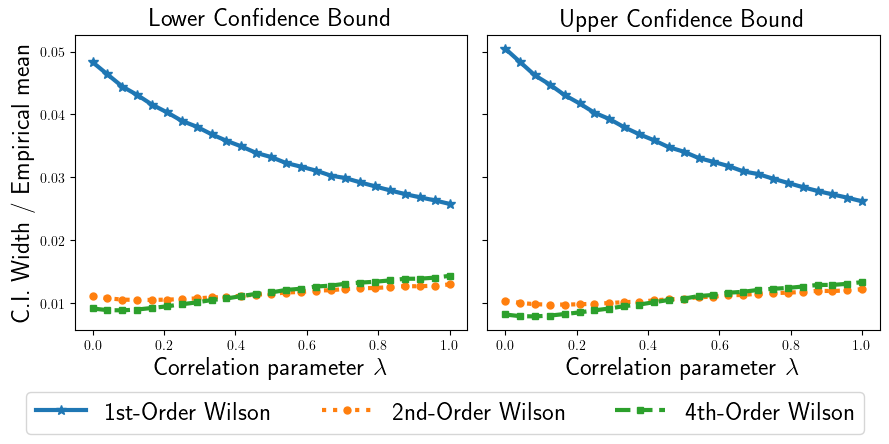

In [11]:
f, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

# Plot the mean and intervals
empirical_mean = samples.mean(axis=(1,2))  # (batch_size,)

styles = [
    dict(marker='*', markersize=7, linestyle="solid", color='C0', linewidth=3),
    dict(marker="o", markersize=5, linestyle="dotted", color='C1', linewidth=3),
    dict(marker="s", markersize=5, linestyle="dashed", color='C2', linewidth=3),
]

keys = ['1st-Order Wilson', '2nd-Order Wilson', '4th-Order Wilson']
for i, key in enumerate(keys):
    ax[0].plot(lam_list, (empirical_mean - left.loc[key]) / empirical_mean, label=key, **styles[i])
    ax[1].plot(lam_list, (right.loc[key] - empirical_mean) / empirical_mean, **styles[i])
    

ax[0].set_xlabel(r'Correlation parameter $\lambda$', fontsize=18)
ax[1].set_xlabel(r'Correlation parameter $\lambda$', fontsize=18)
ax[0].set_ylabel('C.I. Width / Empirical mean', fontsize=18)
ax[0].set_title('Lower Confidence Bound', fontsize=18)
ax[1].set_title('Upper Confidence Bound', fontsize=18)

lgd = f.legend(fontsize=18, loc=8, bbox_to_anchor=(0, -0.13, 1, 1), ncol=5)
plt.tight_layout()


_**Results**_:

Note that the 2nd and 4th order Wilson intervals are significantly tighter than the 1st order Wilson interval. Indeed, the higher order intervals get better with smaller correlations, while the 1st order Wilson interval gets worse.

Further, at smaller correlations, the 4th order interval outperforms the 2nd order interval but the reverse is true at high correlation.

These intuitions are in line with the observations by [Pillutla et al. (2023)](https://arxiv.org/pdf/2305.18447.pdf) in the context of auditing differential privacy in ML.



# Citation

If you find this software useful, please cite [this paper](https://arxiv.org/pdf/2305.18447.pdf):

```
@inproceedings{pillutla2023unleashing,
  author       = {Krishna Pillutla and
                  Galen Andrew and
                  Peter Kairouz and
                  H. Brendan McMahan and
                  Alina Oprea and
                  Sewoong Oh},
  title        = {{Unleashing the Power of Randomization in Auditing Differentially Private
                  ML}},
  booktitle      = {NeurIPS},
  year         = {2023},
}
```
